## Setup

In [ ]:
%%capture
!pip install transformers accelerate datasets evaluate tqdm scikit-learn umap-learn

import torch
import torch.nn as nn
import numpy as np
import random

from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorWithPadding,
    set_seed
)
from torch.utils.data import DataLoader, Dataset

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reproducibility
set_seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


## Dataset

In [ ]:
# logging into hugging face
from huggingface_hub import hf_hub_download, notebook_login


notebook_login()

In [ ]:
dataset = load_dataset("swag", "regular")
dataset = dataset.shuffle(seed=42)

train_ds = dataset['train'].select(range(500))     # smaller slice from train
val_ds   = dataset['validation'].select(range(200)) # smaller slice from val

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.20k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/4.81M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.78M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/73546 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20006 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20005 [00:00<?, ? examples/s]

Train size: 500
Val size: 200


## Load model

In [ ]:
model_name = 'EleutherAI/gpt-neo-1.3B' # thinking about using 'meta-llama/Llama-2-7b-chat-hf'

tokenizer = AutoTokenizer.from_pretrained(model_name)
# Ensure the tokenizer can handle padding
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True, return_dict_in_generate=True)
model.to(device)
model.eval()


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj):

## Helper functions

In [ ]:
def create_prompt(question, answer_choice, use_cot=False):
    """
    `question` is SWAG's 'startphrase'.
    Keep it short or make it more explicit if use_cot=True.
    """
    if use_cot:
        # Attempt a more elaborate chain-of-thought
        prompt = (
            f"Question: {question}\n\n"
            f"Let's reason step by step about the context and find the best completion:\n"
            f"1) Carefully read and interpret the scenario.\n"
            f"2) Consider each possible continuation.\n"
            f"3) Select the most coherent next event.\n"
            f"Therefore, the best completion is: {answer_choice}"
        )
    else:
        # Simple direct prompt
        prompt = (
            f"Question: {question}\n\n"
            f"The best completion is: {answer_choice}"
        )
    return prompt


In [ ]:
def process_data_for_mc(examples, use_cot=False):
    """
    Returns token IDs for all 4 choices, plus the correct label.
    """
    all_input_ids = []
    all_attention_masks = []
    all_labels = []

    for i in range(len(examples['startphrase'])):
        question = examples['startphrase'][i]
        endings = [
            examples['ending0'][i],
            examples['ending1'][i],
            examples['ending2'][i],
            examples['ending3'][i],
        ]
        correct_label = examples['label'][i]

        input_ids_list = []
        attention_mask_list = []
        for choice_idx in range(4):
            prompt = create_prompt(question, endings[choice_idx], use_cot=use_cot)
            tok = tokenizer(prompt, truncation=True, max_length=128)
            input_ids_list.append(tok['input_ids'])
            attention_mask_list.append(tok['attention_mask'])

        all_input_ids.append(input_ids_list)
        all_attention_masks.append(attention_mask_list)
        all_labels.append(correct_label)

    return {
        'input_ids': all_input_ids,
        'attention_mask': all_attention_masks,
        'labels': all_labels
    }

def collate_fn(features):
    """
    features is a list of dictionaries. Each dictionary has:
      - "input_ids": a list of 4 lists (one per choice),
      - "attention_mask": a list of 4 lists,
      - "labels": the correct choice index (integer).
    """
    batch_input_ids = []
    batch_attention_masks = []
    batch_labels = []

    for ex in features:
        # ex is a dict:
        # {
        #   "input_ids": [[tok_ids], [tok_ids], [tok_ids], [tok_ids]],
        #   "attention_mask": [[mask], [mask], [mask], [mask]],
        #   "labels": int
        # }
        batch_input_ids.append(ex["input_ids"])
        batch_attention_masks.append(ex["attention_mask"])
        batch_labels.append(ex["labels"])

    # batch_input_ids is now a list of length batch_size,
    # each item is [4, seq_len_per_choice], etc.

    flat_input_ids = []
    flat_attention_masks = []
    for item_ids, item_mask in zip(batch_input_ids, batch_attention_masks):
        # item_ids is shape [4, variable_length], etc.
        flat_input_ids.extend(item_ids)
        flat_attention_masks.extend(item_mask)

    padded = tokenizer.pad(
        {"input_ids": flat_input_ids, "attention_mask": flat_attention_masks},
        return_tensors='pt'
    )
    # padded["input_ids"] => shape [batch_size*4, max_len]

    # reshape back to [batch_size, 4, max_len]
    bsz = len(batch_input_ids)
    seq_len = padded["input_ids"].shape[1]
    input_ids = padded["input_ids"].view(bsz, 4, seq_len)
    attention_mask = padded["attention_mask"].view(bsz, 4, seq_len)

    # convert labels to a tensor
    labels = torch.tensor(batch_labels, dtype=torch.long)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [ ]:
def evaluate_batch(input_ids, attention_mask):
    """
    Return:
      - log_probs_per_choice: [batch_size, 4]
      - hidden_states_collector: list of length batch_size,
          each entry = array of shape [4, seq_len, hidden_dim].
        This captures token-by-token hidden states for the second-to-last layer (for example).
    """
    bsz, num_choices, seq_len = input_ids.shape
    flat_input_ids = input_ids.view(bsz * num_choices, seq_len)
    flat_attention_mask = attention_mask.view(bsz * num_choices, seq_len)

    with torch.no_grad():
        outputs = model(
            flat_input_ids,
            attention_mask=flat_attention_mask
        )
        logits = outputs.logits  # [bsz*4, seq_len, vocab_size]
        all_hidden_states = outputs.hidden_states[-2]  # pick second-to-last layer

    # Compute teacher-forcing log-likelihood
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = flat_input_ids[:, 1:].contiguous()
    shift_mask   = flat_attention_mask[:, 1:].contiguous()

    loss_fct = nn.CrossEntropyLoss(reduction="none")
    per_token_loss = loss_fct(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1)
    )
    per_token_loss = per_token_loss.view(bsz*num_choices, -1)

    choice_log_probs = []
    for i in range(bsz*num_choices):
        active_loss = per_token_loss[i][shift_mask[i].bool()].sum()
        choice_log_probs.append(-active_loss.item())

    log_probs_per_choice = np.array(choice_log_probs).reshape(bsz, num_choices)

    # Hidden states: shape = [bsz*4, seq_len, hidden_dim]
    # We regroup them for each example
    hidden_states_collector = []
    hstates_np = all_hidden_states.cpu().numpy()
    for i in range(bsz):
        chunk = hstates_np[i*num_choices : (i+1)*num_choices]  # [4, seq_len, hidden_dim]
        hidden_states_collector.append(chunk)

    return log_probs_per_choice, hidden_states_collector


## Inference

In [ ]:
def run_inference(dataset, use_cot=False):
    processed = dataset.map(lambda ex: process_data_for_mc(ex, use_cot=use_cot), batched=True)
    loader = DataLoader(processed, batch_size=8, shuffle=False, collate_fn=collate_fn)

    preds = []
    golds = []
    internals = []
    for batch in tqdm(loader, desc="Inference"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].numpy()

        log_probs, hidden_states = evaluate_batch(input_ids, attention_mask)
        pred_choice = log_probs.argmax(axis=1)
        preds.extend(pred_choice)
        golds.extend(labels)

        internals.extend(hidden_states)

    preds = np.array(preds)
    golds = np.array(golds)
    acc = (preds == golds).mean()
    print(f"\n{'CoT' if use_cot else 'No CoT'} => Accuracy: {acc*100:.2f}%")
    return preds, golds, internals


In [ ]:
print("=== Inference without Chain-of-Thought ===")
preds_no_cot, golds_no_cot, internals_no_cot = run_inference(train_ds, use_cot=False)

print("\n=== Inference with Chain-of-Thought ===")
preds_cot, golds_cot, internals_cot = run_inference(train_ds, use_cot=True)


=== Inference without Chain-of-Thought ===


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it]


No CoT => Accuracy: 41.20%

=== Inference with Chain-of-Thought ===


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [02:28<00:00,  2.36s/it]


CoT => Accuracy: 40.60%


## Train Classifiers

Strictly speaking, “before the answer is generated” might mean we only feed in partial prompts or intercept hidden states partway. For an MVP, we’ll reuse the same final hidden states but treat it as a stand-in for the “pre-answer” classifier.

For after, we do the same but consider we have access to the entire pass.

In [ ]:
def build_features_partial(internals, preds, golds):
    """
    internals[i] has shape [4, seq_len, hidden_dim] for example i.
    We'll average the hidden states across the first half of tokens, across all 4 choices => single vector.
    Label = 1 if pred == gold, else 0.
    """
    X_list = []
    y_list = []
    for i, rep in enumerate(internals):
        # rep: [4, seq_len, hidden_dim]
        seq_len = rep.shape[1]
        half = seq_len // 2
        partial_tokens = rep[:, :half, :]  # [4, half, hidden_dim]
        feat = partial_tokens.mean(axis=(0,1))  # average over choices & tokens => [hidden_dim]
        X_list.append(feat)
        y_list.append(1 if preds[i] == golds[i] else 0)
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    return X, y

def build_features_full(internals, preds, golds):
    """
    Average over all tokens, across all 4 choices => [hidden_dim]
    """
    X_list = []
    y_list = []
    for i, rep in enumerate(internals):
        feat = rep.mean(axis=(0,1))  # [4, seq_len, hidden_dim] -> [hidden_dim]
        X_list.append(feat)
        y_list.append(1 if preds[i] == golds[i] else 0)
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    return X, y

def build_features_blackbox(dataset, preds, golds):
    """
    We'll do it for the *same subset of examples* (train_ds).
    We'll rely on the 'startphrase' field only.
    """
    X_list = []
    y_list = []
    for i, example in enumerate(dataset):
        text = example["startphrase"]
        # get hidden states for just the question
        enc = tokenizer(text, return_tensors='pt', truncation=True, max_length=64).to(device)
        with torch.no_grad():
            out = model(**enc)
            # take second-to-last layer or last layer? We'll be consistent
            # with the second-to-last layer, like above
            h = out.hidden_states[-2].squeeze(0)  # shape [seq_len, hidden_dim]
        feat = h.mean(dim=0).cpu().numpy()  # average across tokens => [hidden_dim]
        X_list.append(feat)
        y_list.append(1 if preds[i] == golds[i] else 0)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    return X, y


In [ ]:
def train_and_evaluate_features(X, y, name=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} => Classifier Accuracy: {acc*100:.2f}%")
    return clf

# -- No CoT variants --
X_no_cot_partial, y_no_cot_partial = build_features_partial(internals_no_cot, preds_no_cot, golds_no_cot)
X_no_cot_full,    y_no_cot_full    = build_features_full(internals_no_cot, preds_no_cot, golds_no_cot)
X_no_cot_black,  y_no_cot_black = build_features_blackbox(train_ds, preds_no_cot, golds_no_cot)

clf_nocot_partial = train_and_evaluate_features(X_no_cot_partial, y_no_cot_partial, name="No CoT Partial")
clf_nocot_full    = train_and_evaluate_features(X_no_cot_full,    y_no_cot_full,    name="No CoT Full")
clf_nocot_black   = train_and_evaluate_features(X_no_cot_black,   y_no_cot_black,   name="No CoT Black-Box")

print("\n-- CoT variants --")
X_cot_partial, y_cot_partial = build_features_partial(internals_cot, preds_cot, golds_cot)
X_cot_full,    y_cot_full    = build_features_full(internals_cot, preds_cot, golds_cot)
X_cot_black,   y_cot_black   = build_features_blackbox(train_ds, preds_cot, golds_cot)

clf_cot_partial = train_and_evaluate_features(X_cot_partial, y_cot_partial, name="CoT Partial")
clf_cot_full    = train_and_evaluate_features(X_cot_full,    y_cot_full,    name="CoT Full")
clf_cot_black   = train_and_evaluate_features(X_cot_black,   y_cot_black,   name="CoT Black-Box")


No CoT Partial => Classifier Accuracy: 53.33%
No CoT Full => Classifier Accuracy: 52.00%
No CoT Black-Box => Classifier Accuracy: 53.33%

-- CoT variants --
CoT Partial => Classifier Accuracy: 56.00%
CoT Full => Classifier Accuracy: 54.00%
CoT Black-Box => Classifier Accuracy: 48.67%


In [ ]:
def show_feature_importance(clf, X, y, title="Feature Importance"):
    r = permutation_importance(clf, X, y, n_repeats=10, random_state=42)
    importances = r.importances_mean
    # get top 10
    top_indices = np.argsort(importances)[::-1][:10]
    print(f"Top 10 feature indices by permutation importance for {title}:")
    for idx in top_indices:
        print(f"  Feature {idx}, Importance: {importances[idx]:.4f}")

# Example: check importance for CoT-Full classifier
show_feature_importance(clf_cot_full, X_cot_full, y_cot_full, title="CoT-Full")


Top 10 feature indices by permutation importance for CoT-Full:
  Feature 1624, Importance: 0.0270
  Feature 1614, Importance: 0.0092
  Feature 683, Importance: 0.0086
  Feature 858, Importance: 0.0064
  Feature 659, Importance: 0.0062
  Feature 1670, Importance: 0.0052
  Feature 291, Importance: 0.0050
  Feature 507, Importance: 0.0050
  Feature 1244, Importance: 0.0050
  Feature 198, Importance: 0.0050


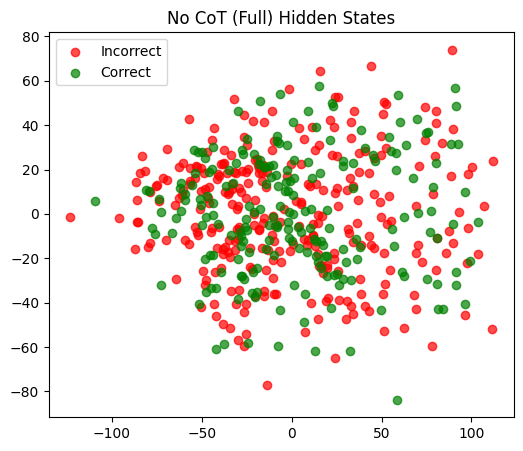

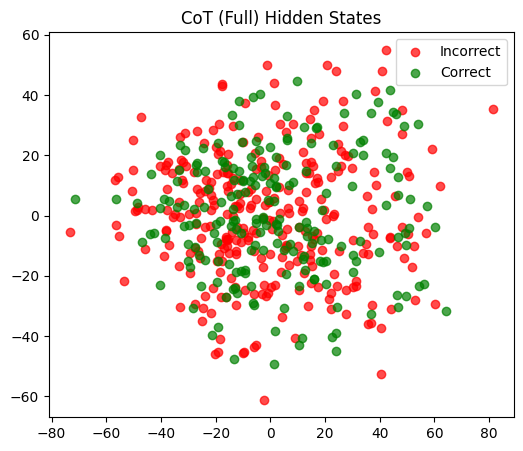

In [ ]:
def plot_representation(X, y, title="Hidden State Representation"):
    reducer = PCA(n_components=2)  # or umap.UMAP()
    emb = reducer.fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(emb[y==0,0], emb[y==0,1], color='red', label='Incorrect', alpha=0.7)
    plt.scatter(emb[y==1,0], emb[y==1,1], color='green', label='Correct', alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()

plot_representation(X_no_cot_full, y_no_cot_full, title="No CoT (Full) Hidden States")
plot_representation(X_cot_full,    y_cot_full,    title="CoT (Full) Hidden States")


## Viz

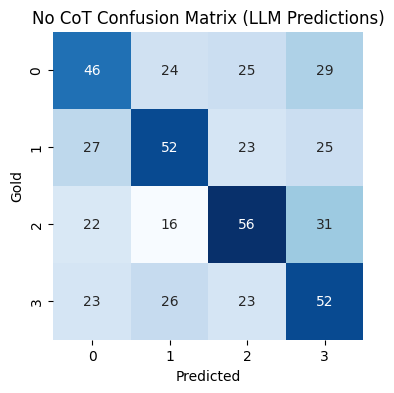

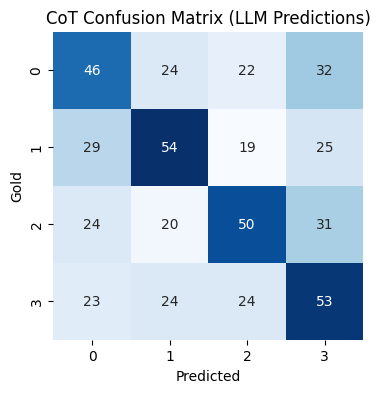

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(preds, golds, title="Confusion Matrix"):
    cm = confusion_matrix(golds, preds)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Gold")
    plt.show()

# For No CoT
plot_confusion_matrix(preds_no_cot, golds_no_cot, title="No CoT Confusion Matrix (LLM Predictions)")

# For CoT
plot_confusion_matrix(preds_cot, golds_cot, title="CoT Confusion Matrix (LLM Predictions)")


In [ ]:
def plot_logprob_distribution(log_probs_per_example, correct_flags, title="Log Probability Distribution"):
    """
    log_probs_per_example: array of shape [num_examples] with the chosen choice's log-prob
    correct_flags: array of bool or 0/1
    """
    correct_lp = log_probs_per_example[correct_flags == 1]
    wrong_lp   = log_probs_per_example[correct_flags == 0]

    plt.figure(figsize=(6,4))
    sns.histplot(correct_lp, color='green', label='Correct', kde=True, alpha=0.5)
    sns.histplot(wrong_lp,   color='red',   label='Incorrect', kde=True, alpha=0.5)
    plt.title(title)
    plt.legend()
    plt.show()

plot_logprob_distribution(chosen_log_prob_no_cot, (preds_no_cot == golds_no_cot).astype(int),
                          title="No CoT Chosen Log Prob: Correct vs. Wrong")

plot_logprob_distribution(chosen_log_prob_cot, (preds_cot == golds_cot).astype(int),
                          title="CoT Chosen Log Prob: Correct vs. Wrong")


NameError: name 'chosen_log_prob_no_cot' is not defined

In [ ]:
def compute_tokenwise_logprobs(input_ids, attention_mask, model):
    """
    Return an array [seq_len] of cumulative log-prob after each token for teacher-forced input.
    """
    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
        logits = outputs.logits  # shape [1, seq_len, vocab_size]
    # Shift by 1
    shift_logits = logits[:, :-1, :].contiguous()  # [1, seq_len-1, vocab]
    shift_labels = input_ids[1:].contiguous()      # [seq_len-1]
    shift_mask   = attention_mask[1:].contiguous() # [seq_len-1]

    loss_fct = nn.CrossEntropyLoss(reduction="none")
    per_token_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    # shape => [seq_len-1]
    # We'll convert to log-probs by negative sign
    per_token_logprob = -per_token_loss

    # Now we can do a cumulative sum over the tokens that are actually used (shift_mask==1)
    cumsum_logprob = []
    current_sum = 0.0
    for i in range(len(per_token_logprob)):
        if shift_mask[i] == 1:
            current_sum += per_token_logprob[i].item()
        cumsum_logprob.append(current_sum)
    return cumsum_logprob
